In [1]:
import pyccl as ccl
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pickle
from scipy.integrate import quad, dblquad
from scipy import interpolate
import time


#Set up a cosmology


cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))



# Strategy


What we want is to evaluate some integrals $\int ... \xi(z_1,z_2,r_p)$ or $\theta$ instead of $r_p$

We use CCL to have a model for $\xi$. Given a power spectrum, ccl returns a $\xi$ but it is slow. I guess (?) it does the Fourier transform every time you call it. 

Thus my way to have fast integrals, is that I generate a 2d array  $\xi (r_{3d},z )$ where $r_{3d}$ is the 3d distance, and I integrate $\xi(r_{3d}(z,z_1,\theta),z)$.

Rather than having 2d interpolation in z and r of my array, I rather find the z index $iz$ which is the best match of the z at which $\xi$ is evaluated, and I interpolate (1d), the $R_{3d},\xi_{iz}(R_{3d})$. One can do better, but this is a fast way, and 1d interp are less problematic than 2d one in python. For small binning in z, I expect this to be a good approximation. 



In [2]:
def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def z_chi(chi):
    return 1/ccl.scale_factor_of_chi(cosmo, chi)-1

def r_3d_rp(rp,z1,z2):
    return ((chi(z1)-chi(z2))**2+(rp)**2)**0.5

def xi_m(r,z):
    return ccl.correlations.correlation_3d(cosmo,1/(1+z),r,'delta_matter:delta_matter')

### Open the Xi_3d array

this array was generated using the  xi_m function defined previously. 

In [3]:
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

'''
Xi_3d=np.zeros((len(Zlist), len(R3d)),dtype=np.float64)
for iz in range(len(Zlist)):
    for ir in range(len(R3d)):
        Xi_3d[iz][ir]=xi_m(R3d[ir],Zlist[iz])
'''

Xi_3d=np.loadtxt('xi3d_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d=np.transpose(Xi_3d)

XI_interp=[]
for iz in range(len(Zlist)):
    XI_interp.append(interpolate.interp1d(R3d, Xi_3d[iz]))

print(np.shape(R3d), ' points for rp and ',np.shape(Zlist), ' for z')


print('minimal distance', round(R3d[0],4), 'Mpc and maximal ', round(R3d[-1],2),'Mpc')
print('minimal redshift', Zlist[0], ' and maximal ', round(Zlist[-1],2))

(40,)  points for rp and  (200,)  for z
minimal distance 0.1 Mpc and maximal  316.23 Mpc
minimal redshift 2.0  and maximal  3.0


In [4]:
# find the best indices with dichotomy

def find_r(x):
    arr=R3d
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

def find_z(x):
    arr=Zlist
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

## 1)True corr

$w_{not \,limber}=\frac{1}{(\Delta z)^2}\int_{-\Delta z/2}^{+\Delta z/2} dz_1\,\, \int_{-\Delta z/2}^{+\Delta z/2}dz_2\,\,  \xi(\bar{z} + z_1,\bar{z} +z_2,\theta)$

In [5]:
def wnotLimber(zmean,Delta_z, rp): # Here we assume tophat n(z), much faster than the following function

    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        index_z=find_z(zmean+z1) # find the best z-index for xi
        #xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

def wnotLimber_n(z_array,nz1,nz2, rp): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
   rp the comoving perp distance in Mpc
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals
    '''

    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]
    
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        #xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts
            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


def wnotLimber_theta(zmean,Delta_z, theta_arcmin): #again, top hat n(z).
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean)
    

    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        index_z=find_z(zmean+z1)
        #xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
        xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2)
            
            if r<0.11:
                return 0
            if r>300:
                return 0
            return xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


def wnotLimber_theta_n(z_array,nz1,nz2, theta_arcmin): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
    theta_arcmin the angular separation in arcmin.
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals.
    '''
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1[iz+1]!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]

    #print('range ',zmin,zmax)
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        rp=theta_rad*ra_cosmo(z1)
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
        
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]



In [13]:
a=time.time()
print('w=',wnotLimber(2.5,0.1, 5))
print(round(time.time(),3)-a,' seconds')

a=time.time()
print('w=',wnotLimber(2.5,0.1, 50))
print(round(time.time(),3)-a,' seconds')

print('large scales are much faster to evaluate!')

w= 0.036783203494221595
6.83827543258667  seconds
w= 0.0020296521149337334
0.8256542682647705  seconds
large scales are much faster to evaluate!


## 2)  Limber corr
$\omega_{L}=  \frac{1}{\Delta z} \int_{-\Delta z/2}^{+\Delta z/2}\, dz\,\, \xi(\bar{z},\bar{z}+z,\theta)$


In [14]:
def wLimber(zmean,Delta_z, rp): 

    zmin=-Delta_z/2
    zmax=+Delta_z/2

    index_z=find_z(zmean)
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
    
    def integrate_z(z):
        r=r_3d_rp(rp,zmean,zmean+z)
        if r>300:
            return 0
        if r<0.11:
            return 0
        return xi_r(r)

    return 1/Delta_z*quad(integrate_z, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    
def wLimber_theta(zmean,Delta_z, theta_arcmin): #return eta+ for a bin centred in z with width Delta_z
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg


    zmin=-Delta_z/2
    zmax=+Delta_z/2

    index_z=find_z(zmean)
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
    
    def integrate_z(z):
        r=r_3d_rp(rp,zmean,zmean+z)
        if r>300:
            return 0
        if r<0.11:
            return 0
        return xi_r(r)

    return 1/Delta_z*quad(integrate_z, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    

In [8]:
rp=2
Dz=0.025
zmean=2.5
(wLimber(zmean,Dz, rp)-wnotLimber(zmean,Dz, rp))/wLimber(zmean,Dz, rp)

0.10162818896655212

# Evaluate the accuracy of Limber for  a bin centre at z=2.5, for various scales ($\theta$ or $r_p$) and bin widths $\Delta z$ 

This test is slow!! as we are computing the ratio for a 2d maps, that is Ndz x Nrp values to evaluate, with many small scales which are hard to evaluate!

In [8]:
zmean=2.5
Nrp=20
Ndz=10

Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(0,np.log10(70),Nrp)
Dz=np.logspace(-2,np.log10(0.8),Ndz)

Dev_rp_dz=np.zeros((Nrp,Ndz))
Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Ndz))
Ratio_theta_dz=np.zeros((Nrp,Ndz))

print(np.shape(Dev_rp_dz))

(20, 10)


In [26]:
for irp in range(Nrp):
    print(irp)
    for jdz in range(Ndz):
        limb=wLimber(zmean,Dz[jdz], Rp[irp])
        not_limb=wnotLimber(zmean,Dz[jdz], Rp[irp])
        
        Dev_rp_dz[irp][jdz]=(limb-not_limb)/not_limb
        Ratio_rp_dz[irp][jdz]=(not_limb)/limb

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


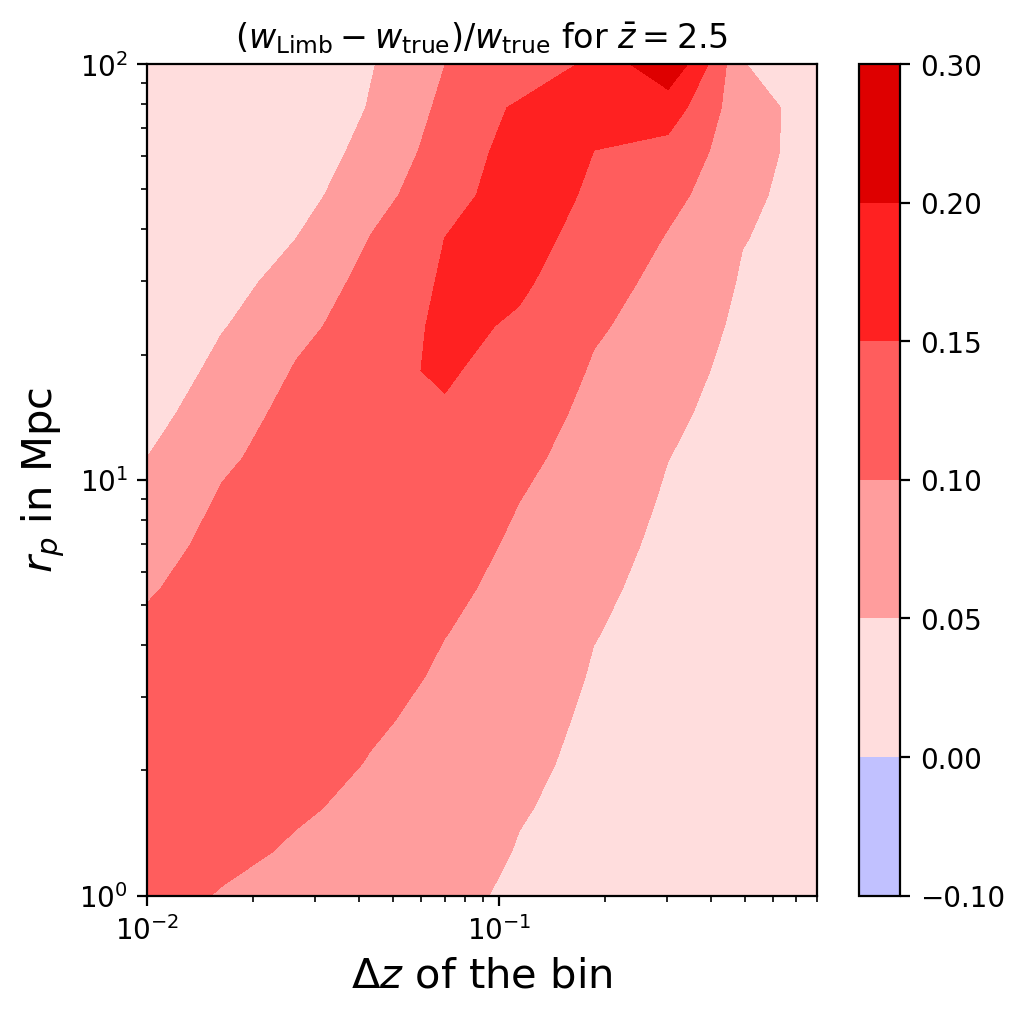

In [28]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 5.4 # sets plot size
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
levels = np.array([-0.1,0,0.05,0.1,0.15,0.2,0.3])


cpf = ax.contourf(Dz,Rp,  Dev_rp_dz, len(levels), levels=levels, cmap='seismic',vmin=-0.4, vmax=0.4)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel('$r_p$ in Mpc',fontsize=15)
ax.set_xlabel('$\Delta z$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$(w_{\rm Limb}-w_{\rm true})/w_{\rm true}$ for $\bar{z}=2.5$')
plt.savefig('Deviation_2p5.png')
#line_colors = ['grey' for l in cpf.levels]
#cp = ax.contour(Z,Rp, Wmean[1][40:60], levels=levels, colors=line_colors)

In [29]:
for itheta in range(Nrp):
    print(itheta)
    for jdz in range(Ndz):
        limb=wLimber_theta(zmean,Dz[jdz], Theta[itheta])
        not_limb=wnotLimber_theta(zmean,Dz[jdz], Theta[itheta])
        Dev_theta_dz[itheta][jdz]=(limb-not_limb)/not_limb
        Ratio_theta_dz[itheta][jdz]=(not_limb)/limb

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


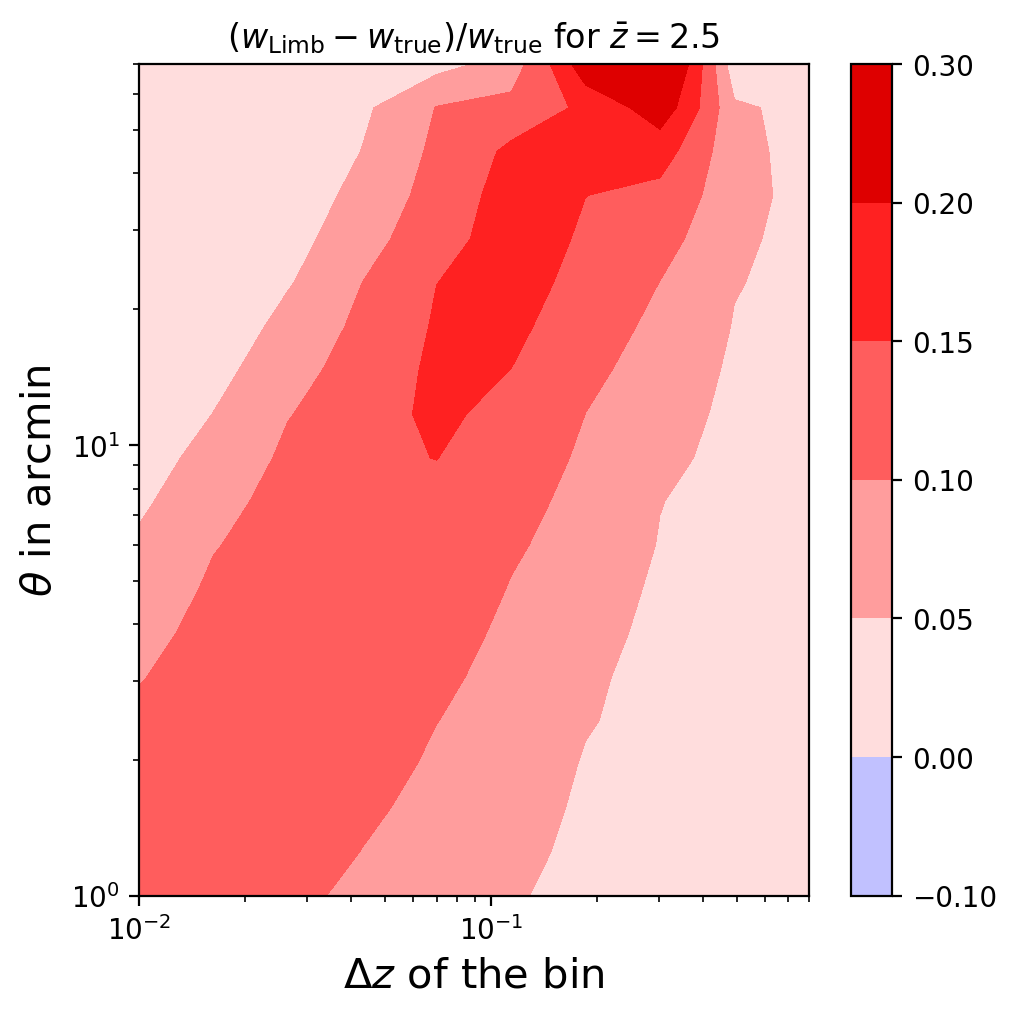

In [30]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 5.4 # sets plot size
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
levels = np.array([-0.1,0,0.05,0.1,0.15,0.2,0.3])


cpf = ax.contourf(Dz,Theta,  Dev_theta_dz, len(levels), levels=levels, cmap='seismic',vmin=-0.4, vmax=0.4)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$\theta$ in arcmin',fontsize=15)
ax.set_xlabel(r'$\Delta z$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$(w_{\rm Limb}-w_{\rm true})/w_{\rm true}$ for $\bar{z}=2.5$')
plt.savefig('Deviation_2p5.png')
#line_colors = ['grey' for l in cpf.levels]
#cp = ax.contour(Z,Rp, Wmean[1][40:60], levels=levels, colors=line_colors)

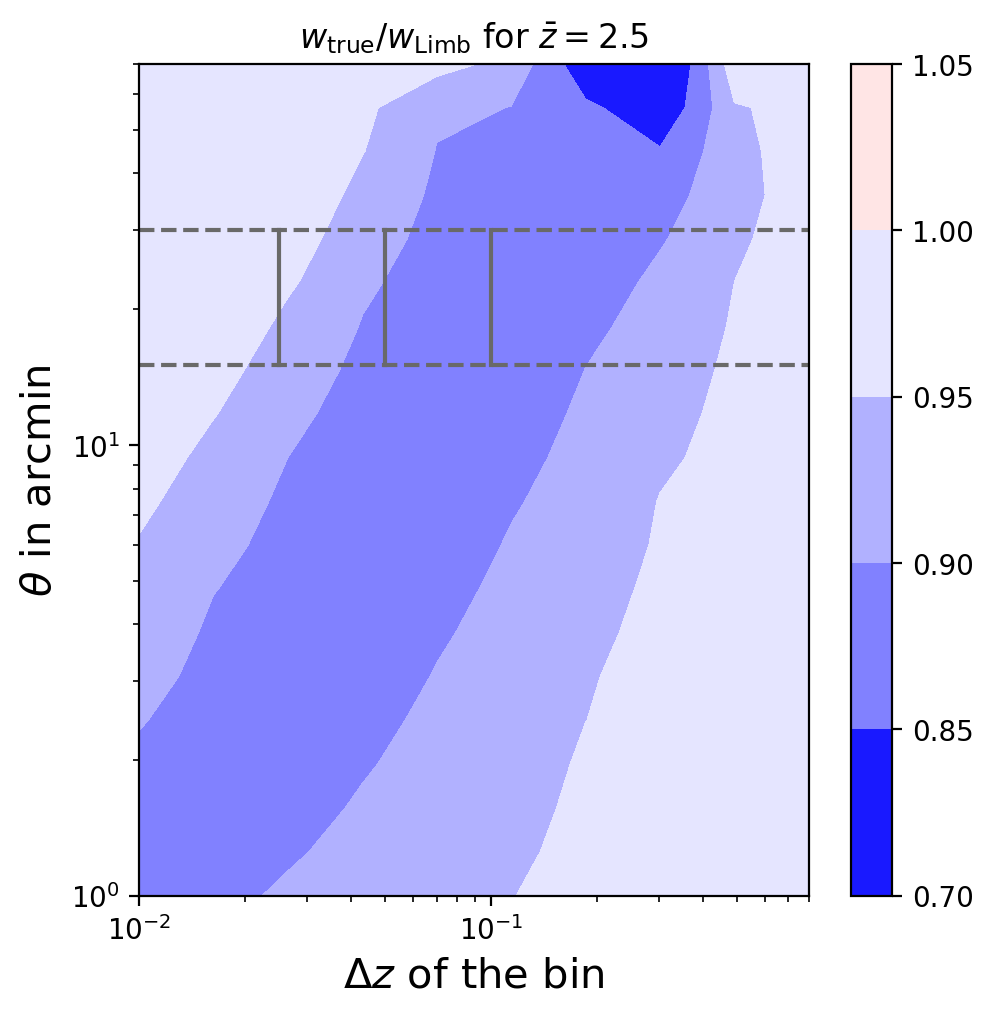

In [31]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 5.4 # sets plot size
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
levels = np.array([0.7,0.85,0.9,0.95,1,1.05])


cpf = ax.contourf(Dz,Theta,  Ratio_theta_dz, len(levels), levels=levels, cmap='seismic',vmin=1-0.5, vmax=1+0.5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$\theta$ in arcmin',fontsize=15)
ax.set_xlabel(r'$\Delta z$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w_{\rm true}/w_{\rm Limb}$ for $\bar{z}=2.5$')
plt.savefig('Ratio_2p5.png')


plt.plot([Dz[0],Dz[-1]],[15,15],linestyle='--',color='dimgrey')
plt.plot([Dz[0],Dz[-1]],[30,30],linestyle='--',color='dimgrey')

plt.plot([0.025,0.025],[15,30],linestyle='-',color='dimgrey')
plt.plot([0.05,0.05],[15,30],linestyle='-',color='dimgrey')
plt.plot([0.1,0.1],[15,30],linestyle='-',color='dimgrey')

plt.savefig('Ratio_2p5.png')
#line_colors = ['grey' for l in cpf.levels]
#cp = ax.contour(Z,Rp, Wmean[1][40:60], levels=levels, colors=line_colors)

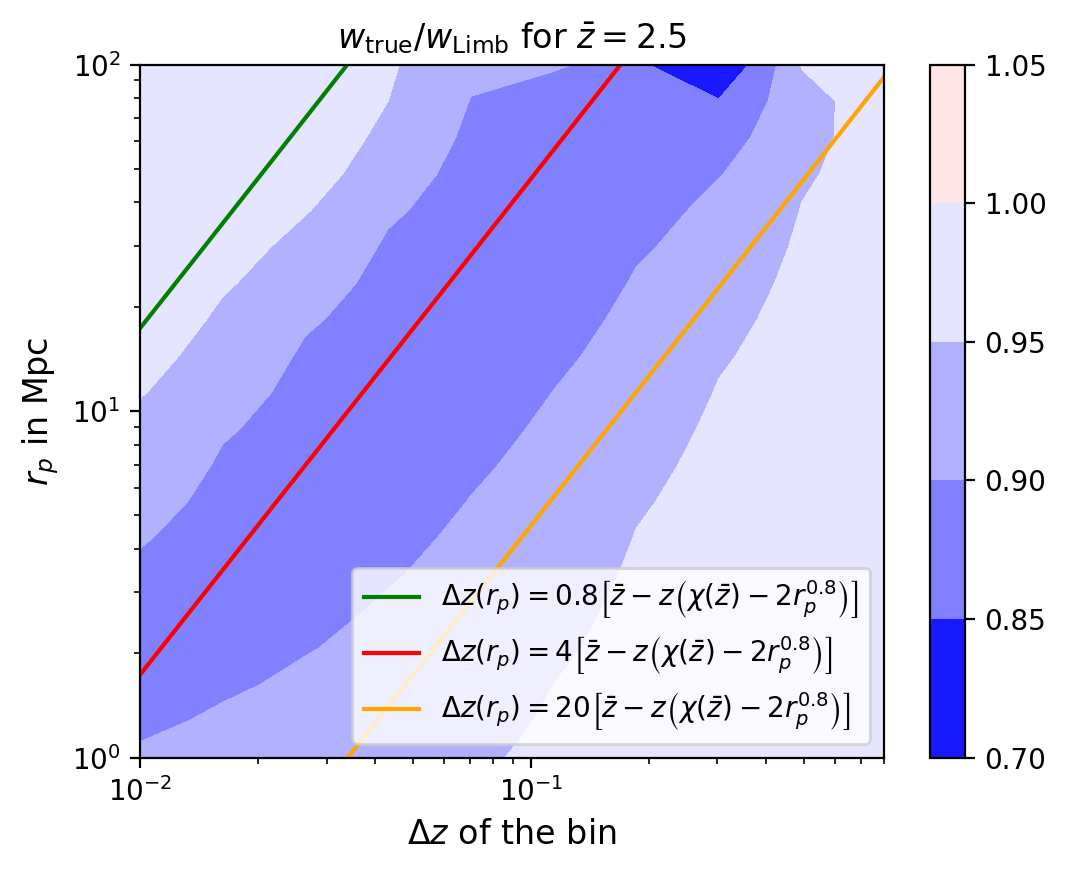

In [95]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 6.,4.5 # sets plot size
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
levels = np.array([0.7,0.85,0.9,0.95,1,1.05])


cpf = ax.contourf(Dz,Rp,  Ratio_rp_dz, len(levels), levels=levels, cmap='seismic',vmin=1-0.5, vmax=1+0.5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$r_p$ in Mpc',fontsize=12)
ax.set_xlabel(r'$\Delta z$ of the bin',fontsize=12)
plt.colorbar(cpf)
plt.title(r'$w_{\rm true}/w_{\rm Limb}$ for $\bar{z}=2.5$')



#plt.plot([Dz[0],Dz[-1]],[15,15],linestyle='--',color='dimgrey')
#plt.plot([Dz[0],Dz[-1]],[30,30],linestyle='--',color='dimgrey')

#plt.plot([0.025,0.025],[15,30],linestyle='-',color='dimgrey')
#plt.plot([0.05,0.05],[15,30],linestyle='-',color='dimgrey')
#plt.plot([0.1,0.1],[15,30],linestyle='-',color='dimgrey')

Dz_rp=[0.8*(zmean-z_chi(chi(zmean)-2*rp**0.7)) for rp in Rp]
plt.plot(Dz_rp,Rp,color='green',label=r'$\Delta z(r_p)=0.8\left[\bar{z}-z\left(\chi(\bar z)-2r_p^{0.8}\right)\right]$')

zmean=2.5
Dz_rp=[4*(zmean-z_chi(chi(zmean)-2*rp**0.7)) for rp in Rp]
plt.plot(Dz_rp,Rp,color='red',label=r'$\Delta z(r_p)=4\left[\bar{z}-z\left(\chi(\bar z)-2r_p^{0.8}\right)\right]$')

Dz_rp=[20*(zmean-z_chi(chi(zmean)-2*rp**0.7)) for rp in Rp]
plt.plot(Dz_rp,Rp,color='orange',label=r'$\Delta z(r_p)=20\left[\bar{z}-z\left(\chi(\bar z)-2r_p^{0.8}\right)\right]$')

plt.xlim(Dz[0],Dz[-1])
plt.legend()
plt.savefig('Ratio_rp_2p5.png')
#line_colors = ['grey' for l in cpf.levels]
#cp = ax.contour(Z,Rp, Wmean[1][40:60], levels=levels, colors=line_colors)

In [34]:
print(Ratio_rp_dz)

[[0.90239774 0.91048805 0.92019228 0.93164117 0.94499647 0.95884998
  0.97152612 0.98151971 0.98993952 0.9979713 ]
 [0.89648044 0.90317113 0.91259867 0.92472109 0.93916184 0.95429964
  0.96854246 0.97930863 0.99018162 0.99606292]
 [0.89223253 0.89658302 0.90528312 0.91783193 0.93405519 0.94995292
  0.96544402 0.97732691 0.98694975 0.99452874]
 [0.89032245 0.89098859 0.89834998 0.9109063  0.92743254 0.94518762
  0.9623433  0.97509769 0.98535351 0.99297921]
 [0.89107152 0.88687411 0.89183573 0.90444148 0.92118352 0.94032339
  0.95933249 0.97212601 0.98207078 0.99177384]
 [0.89503438 0.88468017 0.88630116 0.89720927 0.91477344 0.93513525
  0.95517387 0.97029809 0.98223239 0.99026752]
 [0.9020354  0.88488632 0.88177063 0.89077918 0.90823814 0.92954206
  0.95110533 0.96752738 0.98066112 0.98908233]
 [0.912763   0.88782731 0.87871936 0.88438912 0.90114453 0.92349389
  0.94657966 0.96444036 0.97948963 0.98783328]
 [0.92472902 0.89468831 0.87765909 0.87871851 0.89382843 0.9165687
  0.94138457 

In [35]:
print(Ratio_theta_dz)

[[0.89139518 0.89496295 0.90340373 0.91588776 0.931699   0.9491472
  0.96516165 0.97672179 0.98643715 0.99406551]
 [0.89007693 0.88998605 0.8970625  0.90967357 0.92645718 0.94426292
  0.96148293 0.97463777 0.98506276 0.99256797]
 [0.8912912  0.88661722 0.89127904 0.90336091 0.9212486  0.93975168
  0.95840131 0.97249175 0.98367396 0.99138016]
 [0.8952126  0.88464826 0.88614561 0.8970945  0.91468034 0.93502598
  0.9550043  0.96867965 0.98201935 0.99027606]
 [0.90160707 0.8847902  0.88191747 0.89108493 0.90852738 0.92984796
  0.94976475 0.9677068  0.98056475 0.98920125]
 [0.91116754 0.88739872 0.8789512  0.88518553 0.90194498 0.92416908
  0.94713411 0.96519696 0.97896245 0.9874639 ]
 [0.92199853 0.89283282 0.87766225 0.87963548 0.89534064 0.91794794
  0.94258391 0.96159569 0.97761691 0.98677214]
 [0.93501656 0.90116011 0.87884749 0.87536465 0.88846076 0.91121005
  0.9373367  0.95847716 0.97503966 0.98669157]
 [0.94757705 0.91155944 0.88282996 0.87199733 0.881547   0.90378107
  0.93151226 

# Now fit data wpp assuming top hat n(z):

This is much faster to run, as we are keeping only relatively large scales!

In [15]:
Ndz=2
Z_20=[2.025+i*0.05 for i in range(20)]
Z_40=[2.0125+i*0.025 for i in range(40)]

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)


W_theta1030_dz025=np.zeros((Ntheta,40))
W_theta3050_dz025=np.zeros((Ntheta,40))
W_theta1030_dz05=np.zeros((Ntheta,20))
W_theta3050_dz05=np.zeros((Ntheta,20))

print(np.shape(W_theta1030_dz025))

(10, 40)


In [16]:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(20):
        zmean=Z_20[jdz]
        dz=0.05
        not_limb_1030=wnotLimber_theta(zmean,dz, Theta_10_30[itheta])
        not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz05[itheta][jdz]=not_limb_1030
        W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [17]:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(40):
        zmean=Z_40[jdz]
        dz=0.025
        not_limb_1030=wnotLimber_theta(zmean,dz, Theta_10_30[itheta])
        not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz025[itheta][jdz]=not_limb_1030
        W_theta3050_dz025[itheta][jdz]=not_limb_3050

0
1
2
3
4
5
6
7
8
9


In [18]:
# wpp data
data=np.loadtxt('mock0-w_pp-norsd-theta-min-10-max-30-zbin-40.txt')
Z_025,wpp_10_30_z025,err_wpp_10_30_z025=data[:-1,0],data[:-1,1],data[:-1,2]

data=np.loadtxt('mock0-w_pp-norsd-theta-min-10-max-30-zbin-20.txt')
Z_05,wpp_10_30_z05,err_wpp_10_30_z05=data[:-1,0],data[:-1,1],data[:-1,2]


data=np.loadtxt('mock0-w_pp-norsd-theta-min-30-max-50-zbin-40.txt')
Z_025,wpp_30_50_z025,err_wpp_30_50_z025=data[:-1,0],data[:-1,1],data[:-1,2]

data=np.loadtxt('mock0-w_pp-norsd-theta-min-30-max-50-zbin-20.txt')
Z_05,wpp_30_50_z05,err_wpp_30_50_z05=data[:-1,0],data[:-1,1],data[:-1,2]

In [19]:
# Bias model
data=np.loadtxt('bias_dc2 (2).txt')
Z_bias,bias_model=data[:,0],data[:,1]
bias_law=interpolate.interp1d(Z_bias,bias_model)

In [21]:
# power law for the scale weighting;
alpha=0


Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_mean=[np.sum(W_theta1030_dz025[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_mean=[np.sum(W_theta1030_dz05[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025=Wtheta_1030_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_10_30_dz05=Wtheta_1030_dz05_mean[:-1]*bias_law(Z_05)**2



Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2


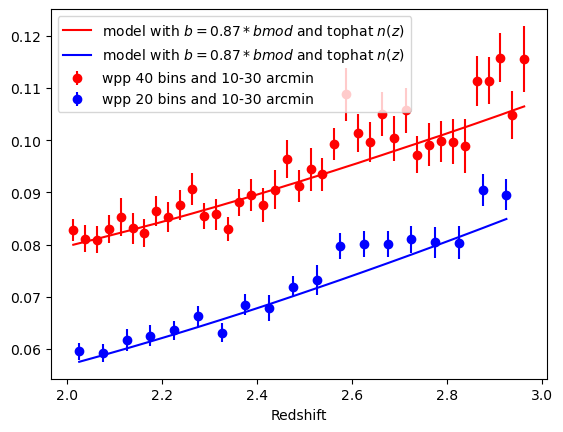

In [34]:
# mismatch in bias between model and data:
eta_bias=0.87


plt.errorbar(Z_025,wpp_10_30_z025,yerr=err_wpp_10_30_z025,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05,yerr=err_wpp_10_30_z05,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.savefig('test_newbias.png')

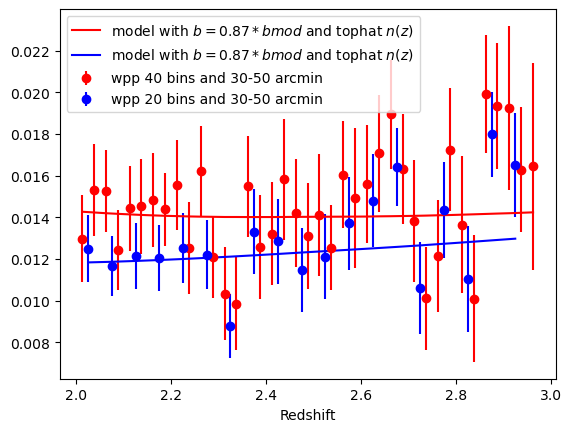

In [37]:
# mismatch in bias between model and data:
eta_bias=0.87

plt.errorbar(Z_025,wpp_30_50_z025,yerr=err_wpp_30_50_z025,color='red',linestyle='',marker='o',label='wpp 40 bins and 30-50 arcmin')
plt.errorbar(Z_05,wpp_30_50_z05,yerr=err_wpp_30_50_z05,color='blue',linestyle='',marker='o',label='wpp 20 bins and 30-50 arcmin')


plt.plot(Z_025,Wb2_30_50_dz025*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_30_50_dz05*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()

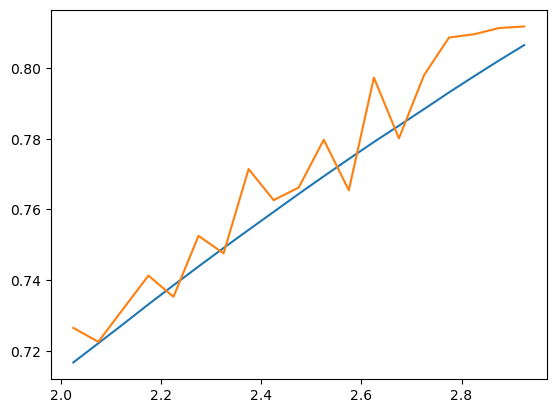

In [39]:
#Does the ratio data[dz=0.05]/[dz=0.025] agrees with the theory one

w05=interpolate.interp1d(Z_05,Wb2_10_30_dz05)
w025=interpolate.interp1d(Z_025,Wb2_10_30_dz025)

wpp_025=interpolate.interp1d(Z_025,wpp_10_30_z025)
wpp_05=interpolate.interp1d(Z_05,wpp_10_30_z05)

plt.plot(Z_05,w05(Z_05)/w025(Z_05))
plt.plot(Z_05,wpp_05(Z_05)/wpp_025(Z_05))

# Now fit the data with a non-limber and n(z) model !

In [48]:
data=np.loadtxt('nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-20bin-z_cosmo.txt')
Z_nz_dz05=data[:,0]
Nz_dz05=np.array([data[:,i+1] for i in range(20)])

for i in range(19):
    norm=np.sum(Nz_dz05[i])
    Nz_dz05[i]=Nz_dz05[i]/norm/0.005

data=np.loadtxt('nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-40bin-z_cosmo.txt')
Z_nz_dz025=data[:,0]
Nz_dz025=np.array([data[:,i+1] for i in range(40)])

for i in range(39):
    norm=np.sum(Nz_dz025[i])
    Nz_dz025[i]=Nz_dz025[i]/norm/0.005


(209, 41)


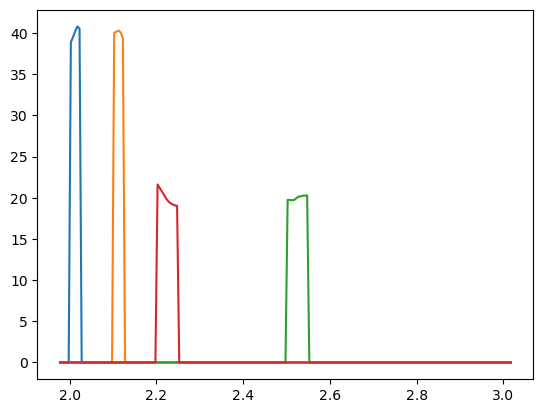

In [49]:
print(np.shape(data))
plt.plot(Z_nz_dz025,Nz_dz025[0])
plt.plot(Z_nz_dz025,Nz_dz025[4])
plt.plot(Z_nz_dz05,Nz_dz05[10])
plt.plot(Z_nz_dz05,Nz_dz05[4])

In [60]:
# As it is slow, I will focus on 1 bin...

W_theta1030_dz025_n=np.zeros((Ntheta,40))
W_theta3050_dz025_n=np.zeros((Ntheta,40))

for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(10,11):
        zmean=Z_40[jdz]
        dz=0.025
        z_restricted=Z_nz_dz025#[jdz*5:min(len(Z_nz_dz025),(3+jdz)*5)]
        nz_restricted=(Nz_dz025[jdz])#[jdz*5:(3+jdz)*5]
        
        not_limb_1030=wnotLimber_theta_n(z_restricted,nz_restricted,nz_restricted,  Theta_10_30[itheta])
        not_limb_3050=wnotLimber_theta_n(z_restricted,nz_restricted,nz_restricted, Theta_30_50[itheta])
    
        W_theta1030_dz025_n[itheta][jdz]=not_limb_1030
        W_theta3050_dz025_n[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


the difference is <1%!!!! top hat is fine


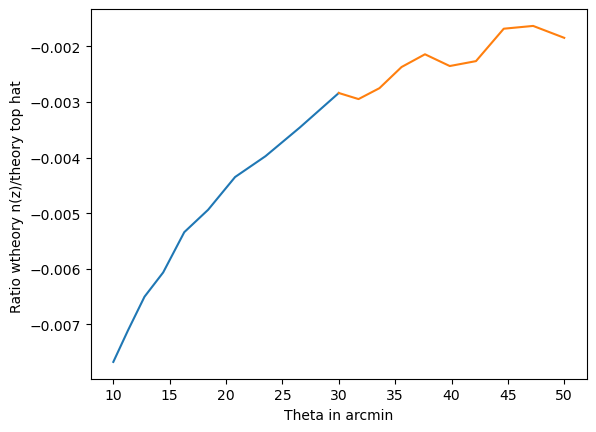

In [63]:
plt.plot(Theta_10_30,(W_theta1030_dz025_n/W_theta1030_dz025)[:,10]-1)
plt.plot(Theta_30_50,(W_theta3050_dz025_n/W_theta3050_dz025)[:,10]-1)
plt.xlabel('Theta in arcmin')
plt.ylabel('Ratio wtheory n(z)/theory top hat ')
print('the difference is <1%!!!! top hat is fine')
plt.title(r'$\Delta z=0.025$')

In [64]:
# As it is slow, I will focus on 1 bin...

W_theta1030_dz05_n=np.zeros((Ntheta,20))
W_theta3050_dz05_n=np.zeros((Ntheta,20))

for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(5,6):
        zmean=Z_20[jdz]
        dz=0.05
        z_restricted=Z_nz_dz05#[jdz*5:min(len(Z_nz_dz025),(3+jdz)*5)]
        nz_restricted=(Nz_dz05[jdz])#[jdz*5:(3+jdz)*5]
        
        not_limb_1030=wnotLimber_theta_n(z_restricted,nz_restricted,nz_restricted,  Theta_10_30[itheta])
        not_limb_3050=wnotLimber_theta_n(z_restricted,nz_restricted,nz_restricted, Theta_30_50[itheta])
    
        W_theta1030_dz05_n[itheta][jdz]=not_limb_1030
        W_theta3050_dz05_n[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


the difference is <1%!!!! top hat is fine


Text(0.5, 1.0, '$\\Delta z=0.05$')

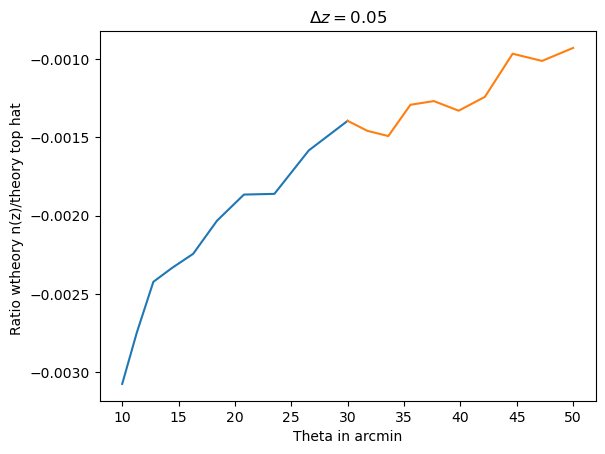

In [67]:
plt.plot(Theta_10_30,(W_theta1030_dz05_n/W_theta1030_dz05)[:,5]-1)
plt.plot(Theta_30_50,(W_theta3050_dz05_n/W_theta3050_dz05)[:,5]-1)
plt.xlabel('Theta in arcmin')
plt.ylabel('Ratio wtheory n(z)/theory top hat ')
print('the difference is <1%!!!! top hat is fine')
plt.title(r'$\Delta z=0.05$')

# Try to fit for angles: 

In [ ]:
Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

alpha=1.7
Wtheta_1030_dz025_mean=[np.sum(W_theta1030_dz025[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_mean=[np.sum(W_theta1030_dz05[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025=Wtheta_1030_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_10_30_dz05=Wtheta_1030_dz05_mean[:-1]*bias_law(Z_05)**2



Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2


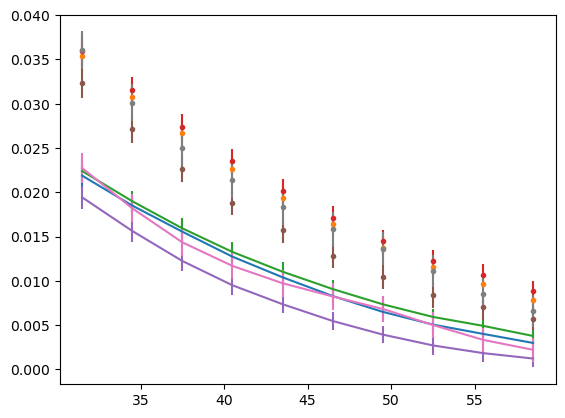

In [69]:
fin1 = np.loadtxt("wpp-norsd-theta-10bins-min-30-max-60-z-20bin (1).txt")
fin2 = np.loadtxt("wpp-theta-10bins-min-30-max-60-z-20bin (1).txt")

theta_bins = np.linspace(30,60,11)
theta_bincen = (theta_bins[1:] + theta_bins[:-1])/2.
z_bins = np.linspace(2,3,21)
z_bincen=(z_bins[1:] + z_bins[:-1])/2.
for ii in [0,3,6,9]:
    plt.errorbar(theta_bincen, fin1[:10, ii], yerr=fin1[10:, ii],label=f"$z =[{z_bins[ii]},{z_bins[ii+1]}] $")
    plt.errorbar(theta_bincen, fin2[:10, ii], yerr=fin2[10:, ii], fmt='.')

In [78]:
Wpp_theory_30_60_dz05=np.array([[bias_law(zmean)**2*wnotLimber_theta(zmean=zmean,Delta_z=0.05, theta_arcmin=theta_arcmin) for theta_arcmin in theta_bincen] for zmean in z_bincen[:-1]])



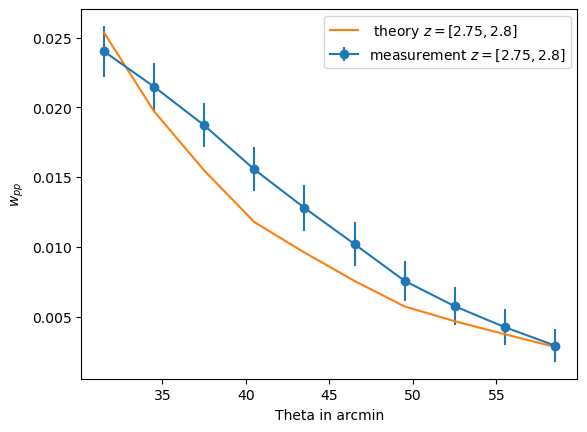

In [88]:
for ii in [15]:
    plt.errorbar(theta_bincen, fin1[:10, ii], yerr=fin1[10:, ii],label=f"measurement $z =[{z_bins[ii]},{z_bins[ii+1]}] $",marker='o')
    plt.plot(theta_bincen,Wpp_theory_30_60_dz05[ii],label=f" theory $z =[{z_bins[ii]},{z_bins[ii+1]}] $")
plt.xlabel('Theta in arcmin')
plt.ylabel(r'$w_{pp}$')
plt.legend()

(0.5, 1.8)

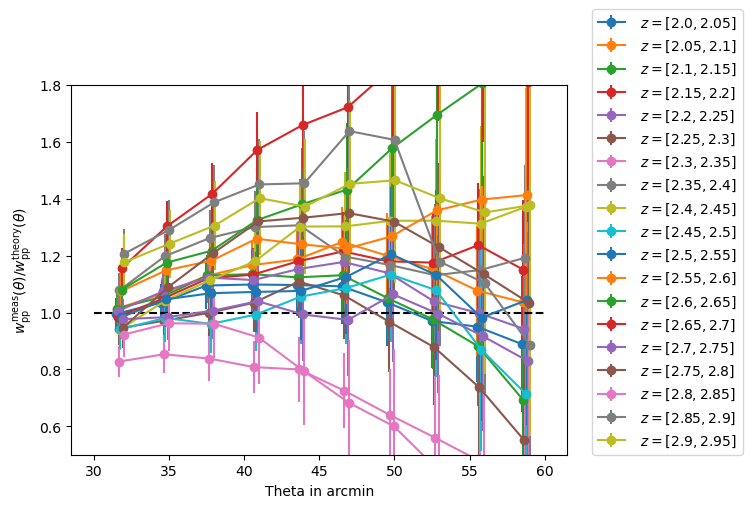

In [109]:
for ii in range(0,19):
    plt.errorbar(theta_bincen+ii*0.03, fin1[:10, ii]/Wpp_theory_30_60_dz05[ii], yerr=fin1[10:, ii]/Wpp_theory_30_60_dz05[ii],label=f" $z =[{z_bins[ii]},{z_bins[ii+1]}] $",marker='o')
    #plt.plot(theta_bincen,Wpp_theory_30_60_dz05[ii],label=f" theory $z =[{z_bins[ii]},{z_bins[ii+1]}] $")
plt.plot([30,60],[1,1],linestyle='--',color='black')
plt.xlabel('Theta in arcmin')
plt.ylabel(r'$w^{\rm meas}_{\rm pp}(\theta)/w^{\rm theory}_{\rm pp}(\theta)$')
plt.legend(loc=(1.05,0.))

plt.ylim(0.5,1.8)
